In [ ]:
!pip install simpy xgboost


In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb


In [ ]:
def queue_simulation(arrival_rate, service_rate, sim_time, num_servers):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=num_servers)

    wait_times = []
    queue_lengths = []

    def customer(env, server):
        arrival = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival)
            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)

    def arrival_process(env, server):
        while env.now < sim_time:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env, server))
            queue_lengths.append(len(server.queue))

    env.process(arrival_process(env, server))
    env.run(until=sim_time)

    return (
        np.mean(wait_times) if wait_times else 0,
        max(queue_lengths) if queue_lengths else 0,
        len(wait_times)
    )


In [ ]:
data = []

for _ in range(1000):
    ar = random.uniform(1, 5)
    sr = random.uniform(1, 5)
    st = random.randint(50, 100)
    ns = random.randint(1, 3)

    avg_wait, max_q, served = queue_simulation(ar, sr, st, ns)

    data.append([ar, sr, st, ns, avg_wait, max_q, served])


In [ ]:
df = pd.DataFrame(data, columns=[
    "arrival_rate", "service_rate", "sim_time",
    "num_servers", "avg_wait", "max_queue", "served"
])

df.head()


,arrival_rate,service_rate,sim_time,num_servers,avg_wait,max_queue,served
0,4.869436,4.813143,100,3,0.004386,2,475
1,1.320858,4.127533,93,3,0.007156,2,138
2,1.937838,1.578619,62,3,0.009974,1,114
3,2.424485,4.693558,54,1,0.209769,5,122
4,3.129776,4.113116,65,2,0.036403,3,209


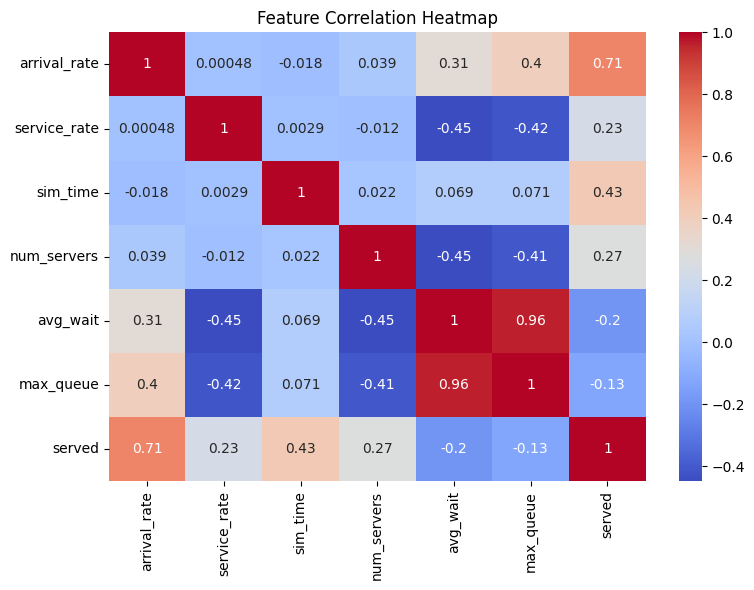

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
X = df[["arrival_rate", "service_rate", "sim_time", "num_servers"]]
y = df["avg_wait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "XGBoost": xgb.XGBRegressor(eval_metric="rmse")
}


In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mse,
        "RMSE": mse ** 0.5,
        "R2": r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)


,Model,MAE,MSE,RMSE,R2
8,Extra Trees,0.835207,3.288020,1.813290,0.911602
9,XGBoost,0.950941,4.025193,2.006288,0.891783
4,Random Forest,0.961068,4.722425,2.173114,0.873038
7,Gradient Boosting,1.409749,6.287742,2.507537,0.830955
3,Decision Tree,1.199925,8.040659,2.835606,0.783828
5,KNN,1.929076,13.413251,3.662411,0.639387
1,Ridge Regression,3.478472,19.843364,4.454589,0.466515
0,Linear Regression,3.480275,19.847734,4.455080,0.466397
2,Lasso Regression,3.263656,21.786182,4.667567,0.414282
6,SVR,2.570407,41.641737,6.453041,-0.119531


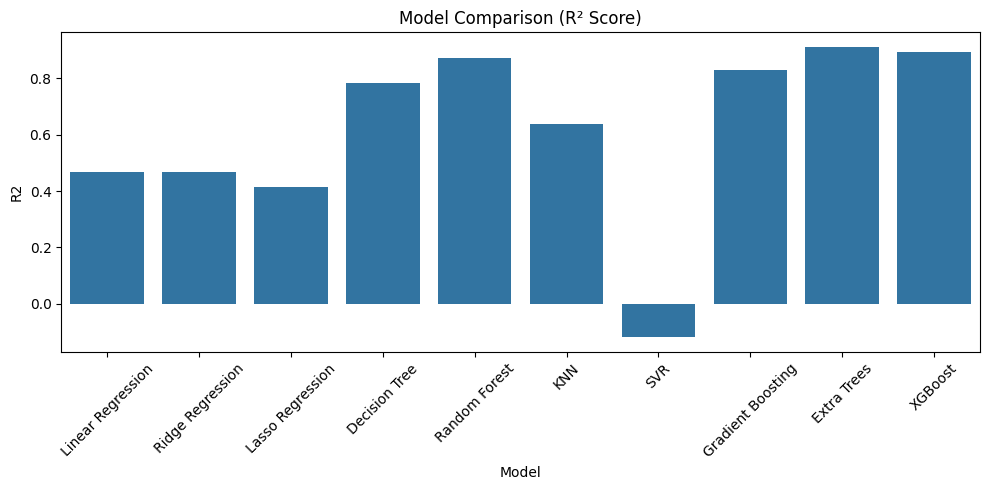

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="R2", data=results_df)
plt.xticks(rotation=45)
plt.title("Model Comparison (R² Score)")
plt.tight_layout()
plt.show()


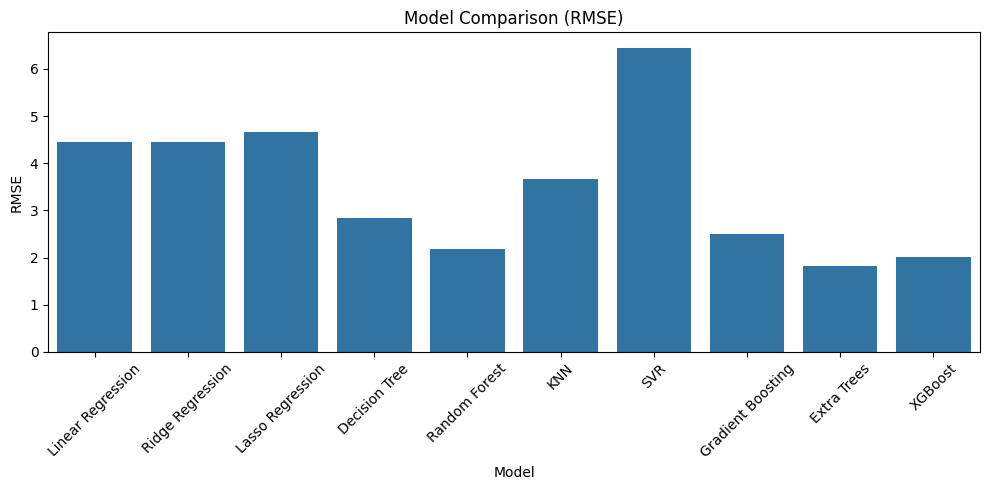

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="RMSE", data=results_df)
plt.xticks(rotation=45)
plt.title("Model Comparison (RMSE)")
plt.tight_layout()
plt.show()


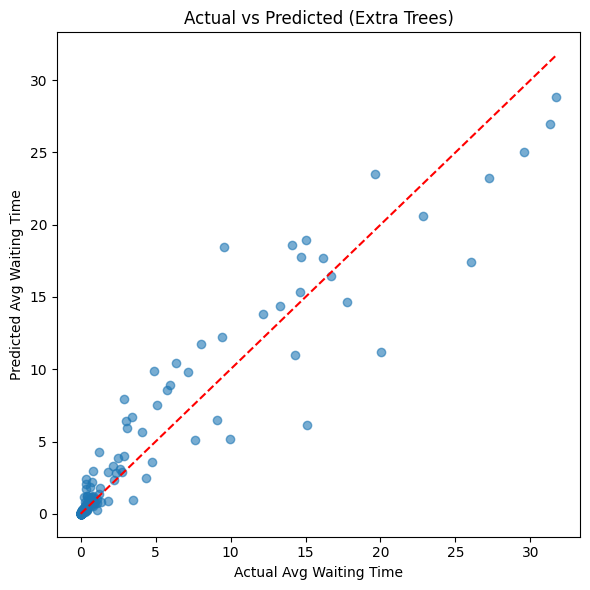

In [ ]:
best_model_name = results_df.sort_values(by="R2", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

best_model.fit(X_train, y_train)
best_preds = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, alpha=0.6)
plt.xlabel("Actual Avg Waiting Time")
plt.ylabel("Predicted Avg Waiting Time")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


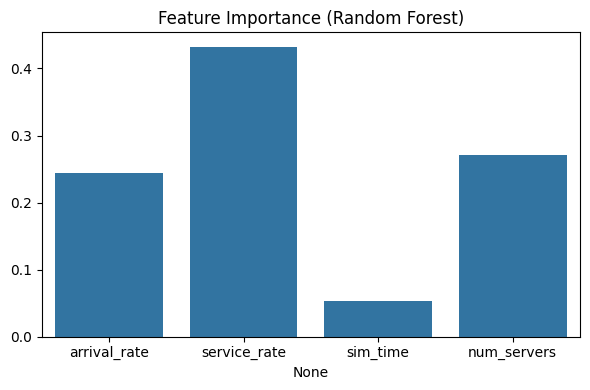

In [ ]:
tree_model = RandomForestRegressor()
tree_model.fit(X_train, y_train)

importances = tree_model.feature_importances_

plt.figure(figsize=(6,4))
sns.barplot(x=X.columns, y=importances)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("simulation_dataset.csv", index=False)
